In [8]:
import torch
import torch_geometric
from torch_geometric.data import Data
import networkx as nx

In [83]:
def create_graphs():
    nx_graphs = [
        nx.grid_2d_graph(i, j)
        for i in range(2, 4)
        for j in range(2, 4)
    ]
    # convert to torch_geometric format
    return nx_graphs
    #return list(map(torch_geometric.utils.from_networkx, nx_graphs))
graphs = create_graphs()
graphs
    

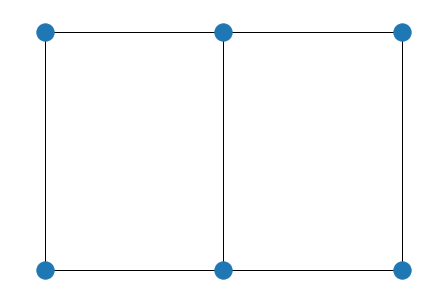

In [89]:
#draw the graph
nx.draw_spectral(graphs[1])

In [66]:
from graphrnn import data

In [64]:
%cd ../../

/home/orausch/sources/graphrnn


In [86]:
c

In [87]:
sampler[0]

{'x': array([[1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 'y': array([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 'len': 4}

In [136]:
G = nx.Graph()
G

In [137]:
G.add_nodes_from([1, 2, 3, 4, 5])

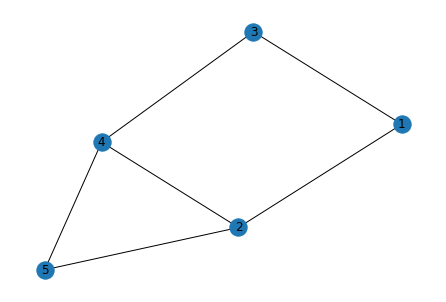

In [140]:
G.add_edges_from([(1, 3), (1, 2), (2, 4), (4, 5), (2, 5), (3, 4)])
nx.draw(G, with_labels=True)

In [139]:
sampler = data.GraphSequenceSampler([G], max_prev_node=2)
adj = nx.to_numpy_array(G)
torch_geometric.utils.from_networkx(G).edge_index

tensor([[0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4],
        [2, 1, 0, 3, 4, 0, 3, 1, 2, 4, 1, 3]])

In [114]:
data.encode_adj(adj, max_prev_node=2)

array([[1., 0.],
       [0., 1.],
       [1., 1.],
       [1., 1.]])

In [224]:
class BFS(T.BaseTransform):
    """
    Start a breath first search from a random node and reorder the edge list so
    that the node indices correspond to the breadth-first search order.
    """

    def __call__(self, data):
        x = data.x
        edge_index = data.edge_index
        assert data.is_undirected(), 'Transform only works for undirected graphs.'
        G = torch_geometric.utils.to_networkx(data, to_undirected=data.is_undirected())

        start_node = torch.randint(0, data.num_nodes, (1,)).item()

        # get the breadth-first search order
        bfs_order = [n for n, _ in nx.bfs_edges(G, start_node)]
        perm = torch.tensor(bfs_order).argsort()

        return torch_geometric.data.Data(x=x, edge_index=perm[edge_index], num_nodes=data.num_nodes)

    def __repr__(self):
        return '{}'.format(self.__class__.__name__)

def encode_bfs_adjacency(data, M):
    """
    Given a pytorch geometric graph `data`, order the nodes according to a BFS started at a random node.

    Then, for each node n compute a new feature x:
    This is a fixed M-dimensional vector, representing the connectivity between
    node n and nodes in the current BFS queue.
    M is a given (possibly emperical) bound on the maximum size of the queue of this BFS. 
    """
    #G = torch_geometric.utils.to_networkx(data)
    G = data
    # get a random start node
    # start_node = torch.randint(0, data.num_nodes, (1,)).item()
    start_node = 1

    num_nodes = G.number_of_nodes() + 1
    x = torch.zeros((num_nodes, M))
    for source, dest in nx.bfs_edges(G, start_node):
        if source - M >= 0:
            x[source, dest] = 1
    return x




In [225]:
data = torch_geometric.utils.from_networkx(G)
data.is_undirected()
draw_data = lambda data: nx.draw_spectral(torch_geometric.utils.to_networkx(data), with_labels=True)

tensor([[0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4],
        [2, 1, 0, 3, 4, 0, 3, 1, 2, 4, 1, 3]])


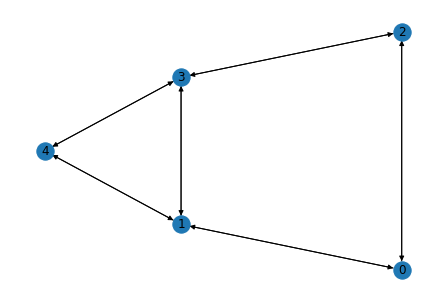

In [226]:

draw_data(data)
print(data.edge_index)

tensor([[3, 3, 1, 1, 1, 4, 4, 2, 2, 2, 0, 0],
        [4, 1, 3, 2, 0, 3, 2, 1, 4, 0, 1, 2]])


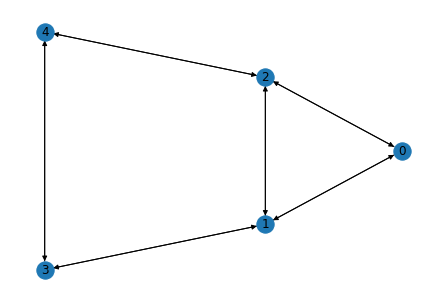

In [228]:
out_data = BFS()(data)
print(out_data.edge_index)
draw_data(out_data)

In [214]:
class AddGraphRNNFeature(T.BaseTransform):

    def __init__(self, M):
        self.M = M

    def __call__(self, data):
        x = data.x
        edge_index = data.edge_index
        num_nodes = data.num_nodes
        # add the graph rnn feature
        x = torch.cat([x, encode_bfs_adjacency(data, self.M)], dim=1)
        return torch_geometric.data.Data(x=x, edge_index=edge_index, num_nodes=num_nodes)

IndexError: index 3 is out of bounds for dimension 0 with size 2

In [241]:
_, indices = torch.sort(out_data.edge_index[0])
edge_index_sorted = out_data.edge_index[:, indices]

In [242]:
edge_index_sorted

tensor([[0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4],
        [1, 2, 3, 2, 0, 1, 4, 0, 4, 1, 3, 2]])

In [243]:
out_data.edge_index

tensor([[3, 3, 1, 1, 1, 4, 4, 2, 2, 2, 0, 0],
        [4, 1, 3, 2, 0, 3, 2, 1, 4, 0, 1, 2]])